# Procedural Generation of Networks
> __Purpose__: The goal of this notebook is to construct a way of 1) representing the activity of neural networks in terms of its baseline parameters (gating variables, voltages, synaptic couplings), and 2) finding a way to then compress that "graph" into an ODE that can be fed to odeint such that a solution to the given network can be found.  Specifically, this NB will build on the code from NB 11 and attempt to generate a "skeleton network" such that the code from NB 11 is essentially refactored (everything is functionalized in order to provide the ability to iterate/loop arbitrarily for the number of neurons in the network).

## 7/9 Advice
- Work backwards. That is, think about a function that outputs on ODE RHS given an exact specification of the parameters, polynomial forms, and so on, for a specified dynamical system. Then think about how to randomly generate this parameters. The key thing for you to focus on is how to represent the graph that I drew as an ODE.

# Current Progress
## Case1: 1 Neuron (Recreation of Previous Results)
1. Finished, replicates previous results

## Case2: 2 Neurons (Recreation of Previous Results)
1. Successfully replicated previous results (exactly? the peaks seem to be more synchronous than the previous)
2. Synaptical coupling mechanism requires a manual approach, not fully automatic yet...

## Case3: Neural Network of Previous Form
1. Yet to start

## Case4: Neural Network with New Form (New Gating Vars, New Synaptic Connections)
1. Yet to start


In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From Previous NBs

In [2]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    Cm = 0.01 #uF/cm^2
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return (1/Cm)*applied_current

In [3]:
def plot_vnmh(x,t,vertIndex=-1,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15
    
    #Extract variables from matrix
    if x.shape[0]==26:
        V1 = x[0,:]
        n1 = x[1,:]
        m1 = x[2,:]
        h1 = x[3,:]

        s1 = x[21,:]

        #plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()

        if gatingVars:
            #plt.subplot(212)
            plt.figure(figsize=(15,10))
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()
    elif x.shape[0]==52:
        V1 = x[0,:]
        n1 = x[1,:]
        m1 = x[2,:]
        h1 = x[3,:]

        V2 = x[26,:]
        n2 = x[27,:]
        m2 = x[28,:]
        h2 = x[29,:]

        s1 = x[21,:]
        s2 = x[42,:] #Might be wrong

        #plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()

        if gatingVars:
            #plt.subplot(212)
            plt.figure(figsize=(15,10))
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            plt.plot(t,n2,label="n2")
            plt.plot(t,m2,label="m2")
            plt.plot(t,h2,label="h2")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()

## Refactoring of odes_sigmoid from NB 11

In [5]:
#Functions replacing non-functionalized calls in odes_sigmoid

def tau_func(V, mean):
    '''
    Function which returns the time constant for the associated variable
    Note that currently we are ignoring the "bump" in the true Tau functions and instead
    simply returning the mean.  The mean has been precalculated and will just be passed
    in and out for form's sake.
    
    In the future may switch to represent Tau functions as Gaussians (which they appear to be), but
    this would require extra parameters (i.e. instead of mean would need the center, width, and upwards bias)
    '''
    return mean


def inf_func(V, v0, sigma):
    '''
    "quasi-Steady-State" ie the x_inf values
    '''
    
    if v0==0 and sigma==0:
        #Avoid division by 0
        x_inf = 0
    else:
        x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
    return x_inf 


def diffEQ_func(tau, x_inf, x):
    '''
    ie dndt, dmdt, dhdt
    Attempting to find a method for incorporating in dVdt
    '''
    if tau==0:
        #Avoid division by 0
        dxdt = 0
    else:
        #for the base equations is just
        dxdt = (1/tau)*(x_inf - x)
    return dxdt

#####################################################################################

def check_SC(current_node,casefile):
    #NOT FINISHED
    
    #Really ought to read this out of a file, 
    #I could have it so that in the list, you enter _coupledNeuron_ followed by _sValue_, but then I'd be adding a even
    # number to my odd number of params, thus dividing by an odd number... and it would require other changes to the code...
    # so this is a quicker fix for now
    
    fullpath = 'C:\Users\14193\desktop\summer2021\brown\hh-comp\NetworkCouplingParams'
    casefilename = fullpath + '\' + casefile + '.csv'
    lineNum = 0
    with open(casefilename, 'r') as file_obj:
        for line in file_obj:        
            if lineNum==current_node:
                as_list = line.split(", ")
                break
            lineNum += 1
            
        for idx in range(len(as_list)/2):
            keys = 
            values = 
    
    #Repo of connections
    #First column: coupled neuron   #Second column: s value
    #There's probably a better way to set up a reciprocal relationship...
    SC1 = np.array([2, s1])
    SC2 = np.array([1, s2])
    
    SC_dict = {1:SC1, 2:SC2}
    #SC_list = [SC1, SC2]
    #SC_list[current_node-1]
    
    return SC_dict.get(current_node)

In [39]:
def odes_sigmoid(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    ######### DEFINITIONS #########
    
    #For synaptic coupling
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    numSC = 5 #Everything set to a default of 5 currently
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    #Convert list input into a matrix
    numParams = 1+4*maxParams+numSC #In this current form, there are 26 parameters per node.  I.e. 1 node is (1,26)
    numRows = int(len(x)/numParams) #Could add a check for whether this is actually an int...
    numCols = numParams
    x = np.reshape(x,(numRows,numCols))
    
    numNodes = 0; numParams = 0
    if len(x.shape)==1:
        #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
        x = np.expand_dims(x,0)
    else:
        numNodes, numParams = x.shape
        
    firstSIndex = numParams-numSC
    #Altering the current for the nodes, essentially weighting them
    #In the test trials in NB 10, we used 1x for node1, and 0x for node2
    node_current = [0]*numNodes
    node_current[0] = 1
    
    infs = np.zeros((numNodes,maxParams))
    taus = np.zeros((numNodes,maxParams))
    dxdts = np.zeros((numNodes,1+5*maxParams))

    ######### CONSTANTS #########
    
    #THIS CATEGORY PROBABLY ALL NEEDS TO CHANGE SINCE WE AREN'T NECESSARILY WORKING WITH THE SAME CHANNELS EACH TIME
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -57.99 #-49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    
    #conductances (S is Siemens)
    gbarK = 0.36 #mS/cm2
    gbarNa = 1.2 #mS/cm2
    gbarL = 0.003 #mS/cm2
    gL = (1/Cm)*gbarL
    #So really there should be other values here for the 4th and 5th gating variables should those get used
    #gbar?(4) = ___
    #gbar?(5) = ___
    
    ### IM ACTUALLY JUST GOING TO IGNORE THE S VALUES I PASSED IN FOR NOW ###
    #For the synaptic coupling: 
    #^20 was a "good value" (ie one for which it functioned) in the previous NB
    gbars = [20] * numSC
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes):  
        #For now, defining every neuron the same, but can change the "n,m,h" values...
        gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
        gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
        #Again, would need to add something for the 4th and 5th gating variables should they exist
        #...
        
        #Synaptic couplings: ie gbar * s
        #This is still not perfect since I did 5 manually, this is still not an automatic process...
        #I could loop from 1+maxParams*3 to the end, this would work for any number of s's
        #firstSIndex
        svars = [0]*numSC
        #svars = [x[nodeTemp,1+4*maxParams], x[nodeTemp,2+4*maxParams], x[nodeTemp,3+4*maxParams], x[nodeTemp,4+4*maxParams], x[nodeTemp,5+4*maxParams]]
        #^Just completely ignoring this for now
        
        #Simplification: check connection in external function
        SC_repo = check_SC(nodeTemp+1)
        if SC_repo is not None and len(SC_repo)==1:
            pass #Just ignore the couplings, they're already set to zero
        elif SC_repo is not None and len(SC_repo)>1:
            #Still manual, just trying to see if I can get it to work
            SC_neuron1 = int(SC_repo[0])
            s1 = SC_repo[1]

            #Now retrieve its one coupled pair:
            SC_repo = check_SC(SC_neuron1)
            SC_neuron2 = int(SC_repo[0])
            s2 = SC_repo[1]
            
            vnode_couplings = [SC_neuron1, SC_neuron2, 0, 0, 0]
            svars = [s1, s2, 0, 0, 0]
            
            my_zeros = [0]*(firstSIndex-1)
            svars_full = my_zeros+svars
            vnode_couplings_full = my_zeros+vnode_couplings
        else:
            pass
            #Still need to build out this functionality
            
        gs = np.array(gbars) * np.array(svars)
        
        ###########################################################################################

        #Define the steady state (inf) values, and the time constants (tau)
        #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
        for param in range(maxParams):
            #inf(V, v0, sigma)
            infs[nodeTemp,param] = inf_func(x[nodeTemp,0], x[nodeTemp,param+(1+maxParams)], x[nodeTemp,param+(1+2*maxParams)])
            #tau(V, mean)
            taus[nodeTemp,param] = tau_func(x[nodeTemp,0], x[nodeTemp,param+(1+3*maxParams)])

        #Define each ODE    
        for param in range(numParams): 
            if param==0:
                #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
                
                #TERM 1
                ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                #Would need to include the 4th and 5th gating variables somehow...
                #How to make this automatic instead of manual...
                
                #TERM 2
                synCoups = 0
                if numNodes==1:
                    # Only 1 node, so it cannot be coupled to another node 
                    pass
                else:
                    for idx in range(numSC):
                        synCoups += gs[idx]*(ES[idx]-x[vnode_couplings_full[idx],0])
                        #^ Terms: (conducance gs_x) * (ES - V)
                    
                #TERM 3
                appliedCurrent = I(t,vI)*node_current[nodeTemp]

                dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
            elif param<(maxParams+1): #ie the gating variables
                #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                dxdts[nodeTemp,param] = diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
            elif param>=firstSIndex and sum(x[nodeTemp,firstSIndex:])==0: #ie if all the s vars are equal to zero
                break #ie just leave them as zero, and we are done with the loop so we can just break
            elif param>=firstSIndex:
                #tau is set manually...
                tau_s = 30 #ms
                s_inf = 10.0/11.0 
                beta_s = 1/tau_s
                
                #This is still manual...
                #Note that even if s1, s2 = 0, ds1dt is still equal to alpha_s1
                #This still isn't fleshed out correctly...
                if numNodes==1:
                    pass #ie dsdts remain zeros
                else:
                    s = svars_full[param]
                    coupled_neuron = vnode_couplings_full[param]
                    alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                    dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 
                
                #This should be the last case, it will run once the way it currently configured
                break
            else:
                pass
                #Should just be equal to zero, so leave as is (matrix is initialized as zeros)
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    return ODE_list

## Case1

Burn in run, looking for NO oscillations
(26, 2000)


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


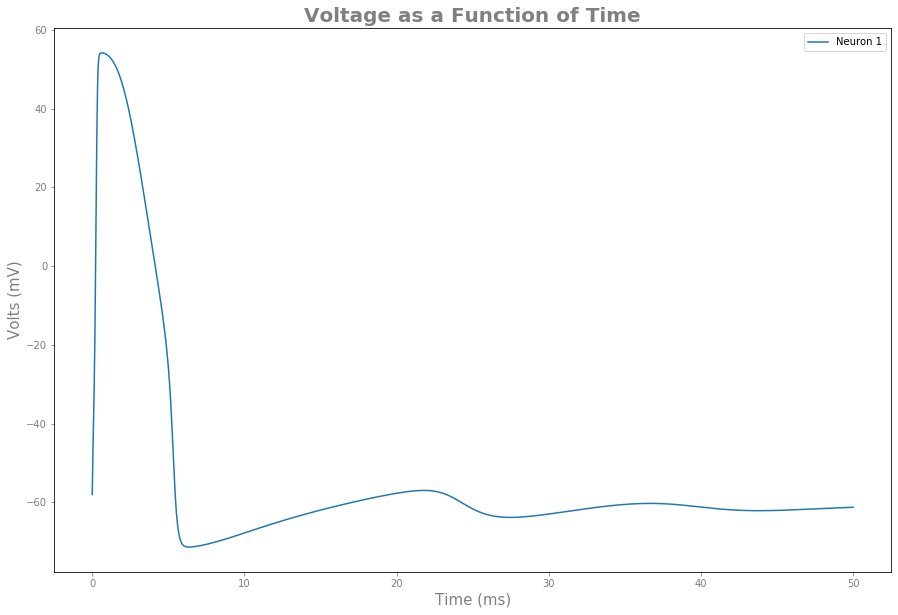

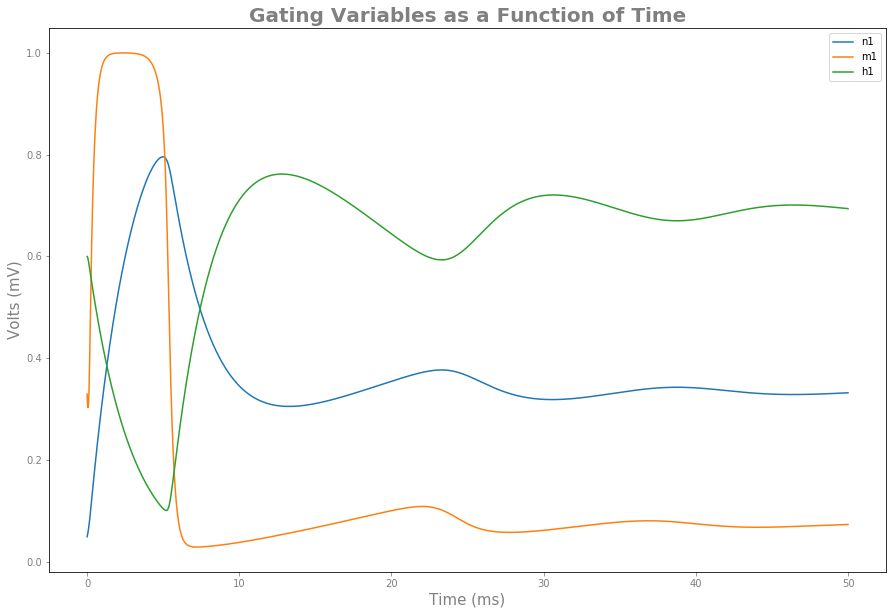

In [21]:
print("Burn in run, looking for NO oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810

node1 = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0,
         0,0,0,0,0] #Synaptic couplings
node2 = node1

node1 = np.array(node1)
#node2 = np.array(node2)
#network_params = np.concatenate((node1, node2), axis=0)
network_params = node1

x = odeint(odes_sigmoid,network_params,t,args=(I,vI))
x = np.transpose(x)

print(x.shape)

plot_vnmh(x,t,gatingVars=True)
#print("-----------------------------------------------------------------------------------")

Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


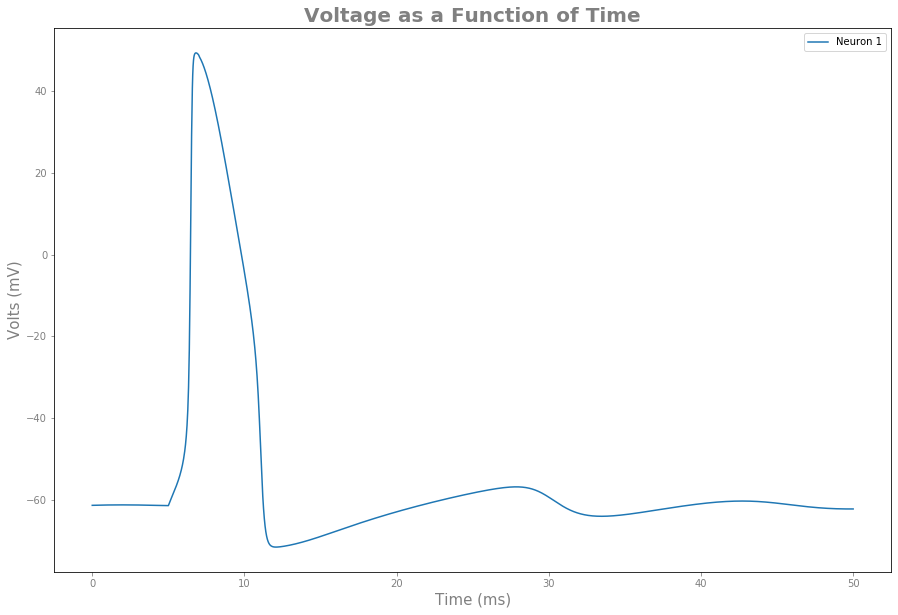

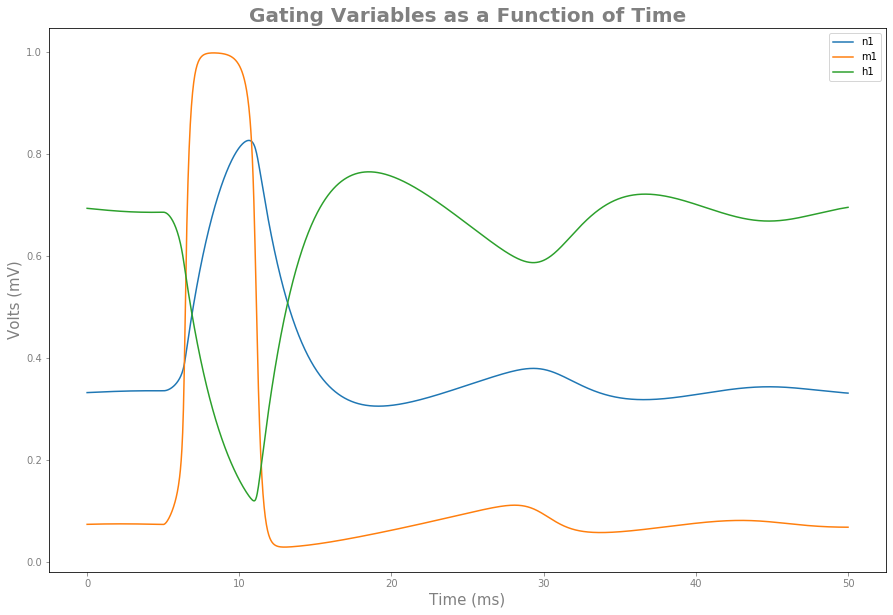

In [22]:
#Now grab the burned in values from the previous run
node1_BI = node1

node1_BI[0] = x[0,-1] #V
node1_BI[1] = x[1,-1] #n
node1_BI[2] = x[2,-1] #m
node1_BI[3] = x[3,-1] #h
node1_BI[21] = x[21,-1] #s

network_params_BI = node1_BI

print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_sigmoid,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,gatingVars=True)

^These graphs are clearly incorrect, just judging from the order of magnitude of the y axes.

## Things to Recall about Synaptic Coupling

1. Technically, the synaptic coupling variable s goes to the other neuron...
    - So either need to find some way to connect neurons (i.e. actually tell which is connected to which...) or just "built this in" such that the s fed in through the parameters is the "correct" s (i.e. already "switched"...)
2. Had to turn off the current for neuron 2 in order to get oscillations...  How does this generalize to more than 2 neurons? Does only 1 recieve current?
3. Need to set ES values somewhere, currently they're all just zero...

## Case2

Burn in run, looking for NO oscillations


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


(52, 2000)


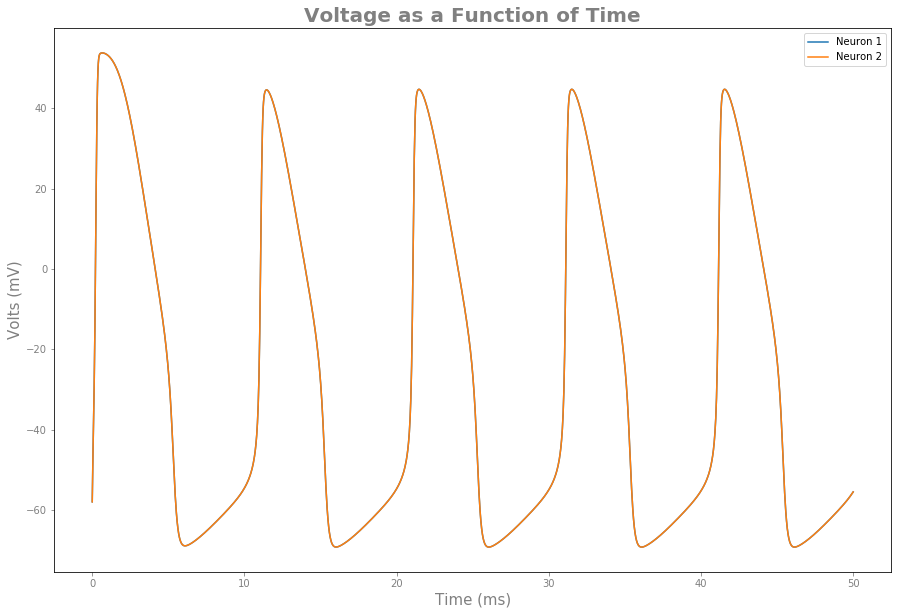

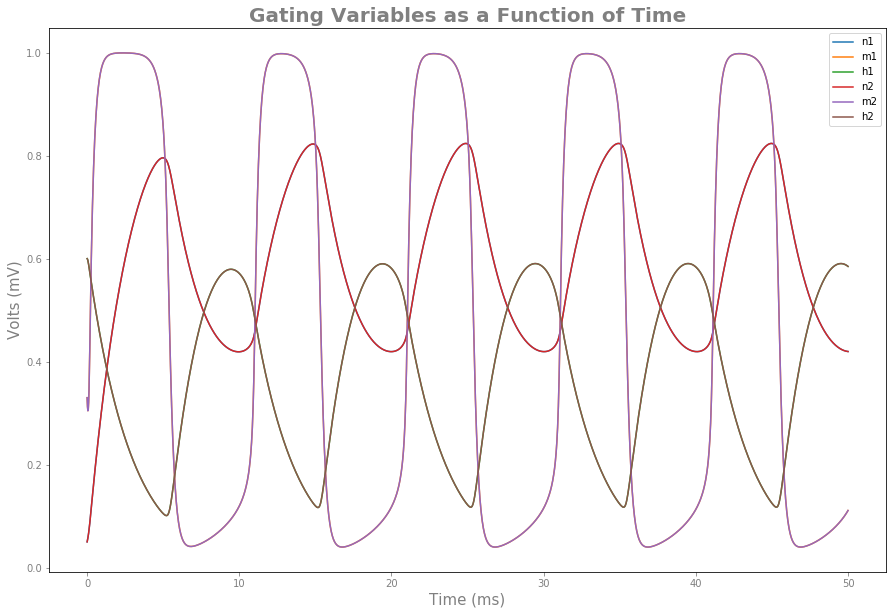

In [40]:
print("Burn in run, looking for NO oscillations")
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810
#############################################################
s1 = 0.006537
s2 = s1

node1 = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0,
         s1,s2,0,0,0] #Synaptic couplings
node2 = node1

node1 = np.array(node1)
node2 = np.array(node2)
network_params = np.concatenate((node1, node2), axis=0)

x = odeint(odes_sigmoid,network_params,t,args=(I,vI))
x = np.transpose(x)

print(x.shape)

plot_vnmh(x,t,gatingVars=True)

Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected


C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\14193\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


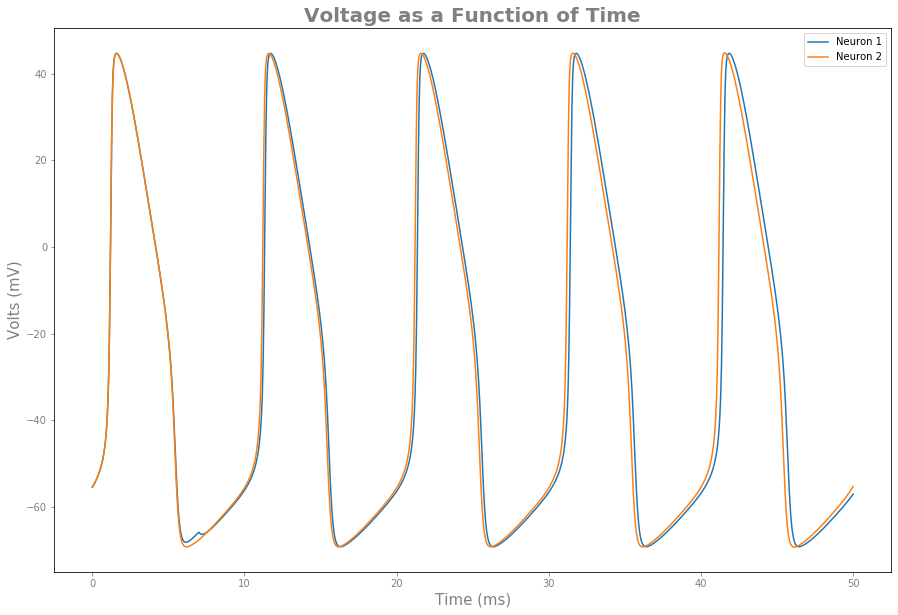

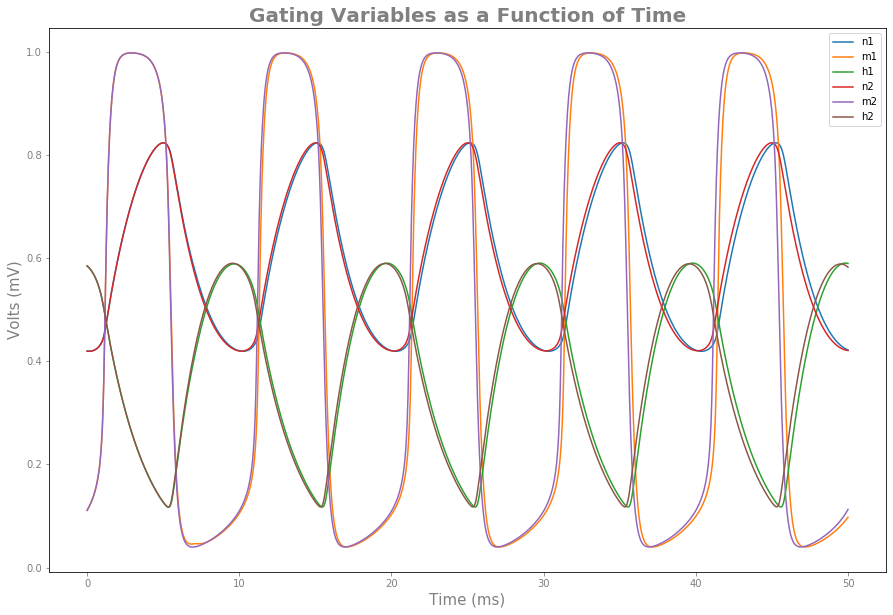

In [41]:
#Now grab the burned in values from the previous run
node1_BI = node1
node2_BI = node2

node1_BI[0] = x[0,-1] #V
node1_BI[1] = x[1,-1] #n
node1_BI[2] = x[2,-1] #m
node1_BI[3] = x[3,-1] #h
node1_BI[21] = x[21,-1] #s

node2_BI[0] = x[26,-1] #V
node2_BI[1] = x[27,-1] #n
node2_BI[2] = x[28,-1] #m
node2_BI[3] = x[29,-1] #h
node2_BI[21] = x[42,-1] #s
network_params_BI = np.concatenate((node1_BI, node2_BI), axis=0)

print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_sigmoid,network_params_BI,t,args=(I,vI))
x = np.transpose(x)

plot_vnmh(x,t,gatingVars=True)